### Packages loading

In [1]:
import sys
sys.path.insert(0, '..')
import numpy as np
import random
import qiskit
import qtm.evolution
import qtm.state
import qtm.qcompilation
import qtm.ansatz
import qtm.constant
from qtm.evolution import environment, mutate, selection, crossover, utils
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


In [9]:
qtm.ansatz.g2gnw(4,2).depth()

18

In [3]:
num_qubits = 4
num_gibbs_qubits = 2
beta = 1
def compilation_gibbs_fitness(qc: qiskit.QuantumCircuit, num_steps = 10):
    compiler = qtm.qcompilation.QuantumCompilation(
        # u=qtm.ansatz.g2gnw(4, 2),
        u = qc,
        vdagger=qtm.state.construct_tfd_state(num_gibbs_qubits, beta = beta).inverse(),
        optimizer='adam',
        loss_func='loss_fubini_study'
    )
    compiler.fit(num_steps=num_steps, metrics = ['gibbs'], verbose=0)
    return np.average(compiler.loss_values)
def compilation_gibbs_threshold(fitness_value):
    if fitness_value < 0.1:
        return True
    return False


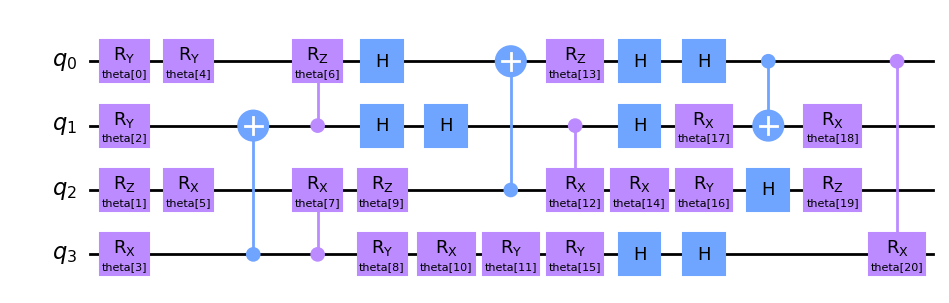

In [6]:
env2 = environment.EEnvironment('./ga_4qubits_compilation_gibbs_fitness_2023-10-20.envobj')
env2.best_candidate.qc.draw('mpl')